# Analysis of ATLAS-GAN results

Let's take a look at the results of the DCGAN trained to generate ATLAS RPV SUSY events.

In [1]:
from __future__ import print_function

import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import torch
from torch.autograd import Variable

from pyjet import cluster, DTYPE_PTEPM

%matplotlib notebook

In [2]:
def generate_samples(generator, n, noise_dim=64):
    # Generate input noise
    noise = Variable(torch.FloatTensor(n, noise_dim, 1, 1)
                 .normal_(0, 1))
    # Generate new samples
    samples = generator(noise)
    return samples.data.numpy().squeeze(1)

def correct_samples(x, thresh=0.00008):
    x = x.copy()
    x[x < thresh] = 0
    return x

def draw_image(x, vmin=None, vmax=None, xlabel='$\eta$', ylabel='$\phi$',
               draw_cbar=True, ax=None, figsize=(5,4), **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(x.T, extent=[-2.5, 2.5, -3.15, 3.15],
                    norm=LogNorm(vmin, vmax), aspect='auto',
                    origin='lower', **kwargs)
    if draw_cbar:
        cbar = plt.gcf().colorbar(cax)
        cbar.set_label('Normalized Energy')
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

In [3]:
def build_jets(image):
    eta_min, eta_max = -2.5, 2.5
    extent = eta_min, eta_max, -np.pi, np.pi
    bins = 64
    eta_edges = np.linspace(eta_min, eta_max, bins + 1)
    phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
    eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
    phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
    X, Y = np.meshgrid(eta, phi)
        
    clusters = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
    E = image.T
    clusters['pT'] = E.ravel()
    clusters['eta'] = X.ravel()
    clusters['phi'] = Y.ravel()
    clusters['pT']=6072947*clusters['pT']/np.cosh(clusters['eta'])
    event = clusters[clusters['pT']>100]
    sequence = cluster(event, R=1.0, p=-1)
    jets = sequence.inclusive_jets(ptmin=200000)
    jets = [jet for jet in jets if (abs(jet.eta) < 2.0)]
    return jets

## Load training results

In [4]:
results_dir = '/bigdata/shared/atlas_rpv/AtlasDCGAN_000'

In [5]:
ls $results_dir

discriminator.torch   dis_outputs_real.npy  gen_samples.npy
dis_losses.npy        generator.torch       out.log
dis_outputs_fake.npy  gen_losses.npy        README


In [6]:
# Load the generator
generator = torch.load(os.path.join(results_dir, 'generator.torch'))
generator.cpu().eval()

Generator(
  (network): Sequential(
    (0): ConvTranspose2d (64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Sigmoid()
  )
)

In [7]:
# Load the result arrays
dis_losses = np.load(os.path.join(results_dir, 'dis_losses.npy'))
gen_losses = np.load(os.path.join(results_dir, 'gen_losses.npy'))
dis_outputs_real = np.load(os.path.join(results_dir, 'dis_outputs_real.npy'))
dis_outputs_fake = np.load(os.path.join(results_dir, 'dis_outputs_fake.npy'))
gen_samples = np.load(os.path.join(results_dir, 'gen_samples.npy'))

<IPython.core.display.Javascript object>


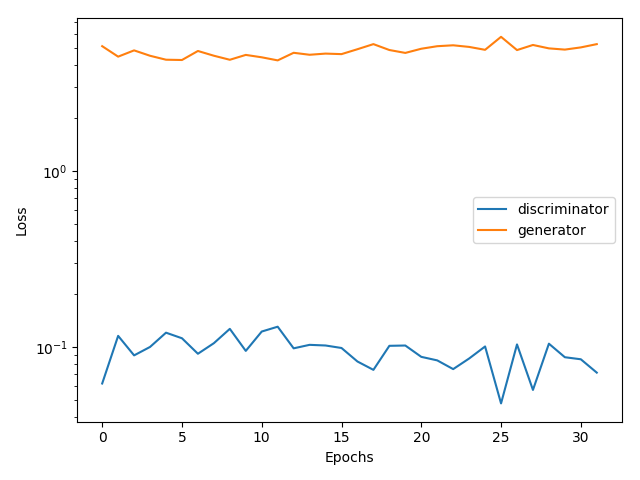

In [8]:
# Plot training loss
plt.figure()
plt.semilogy(dis_losses, label='discriminator')
plt.semilogy(gen_losses, label='generator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.tight_layout()

<IPython.core.display.Javascript object>


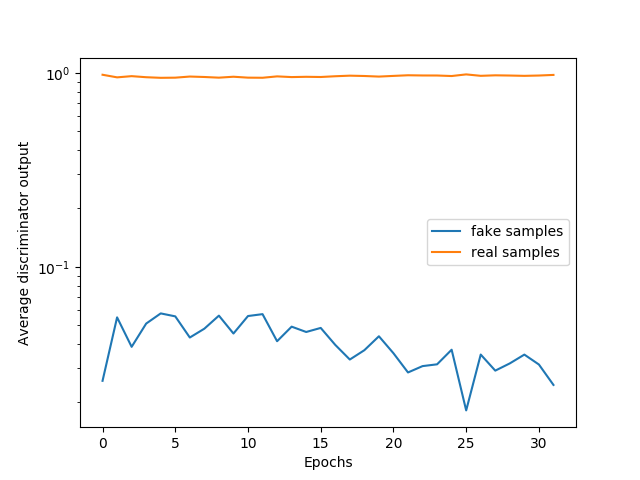

In [9]:
# Plot the discriminator average outputs per epoch
plt.figure()
plt.semilogy(dis_outputs_fake, label='fake samples')
plt.semilogy(dis_outputs_real, label='real samples')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Average discriminator output')

## Draw samples generated during training

In [10]:
corrected_gen_samples = correct_samples(gen_samples)

epoch 0


<IPython.core.display.Javascript object>


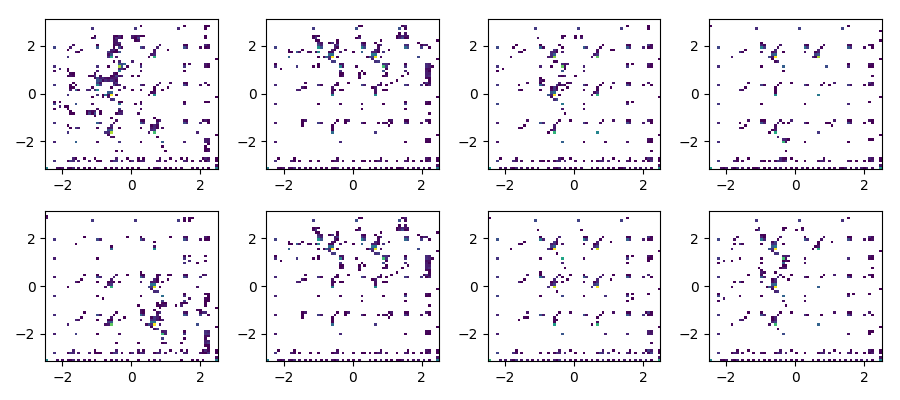

epoch 1


<IPython.core.display.Javascript object>


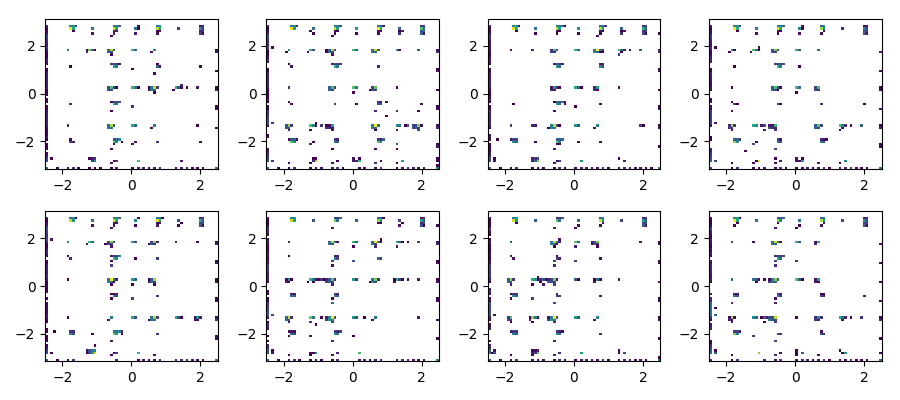

epoch 2


<IPython.core.display.Javascript object>


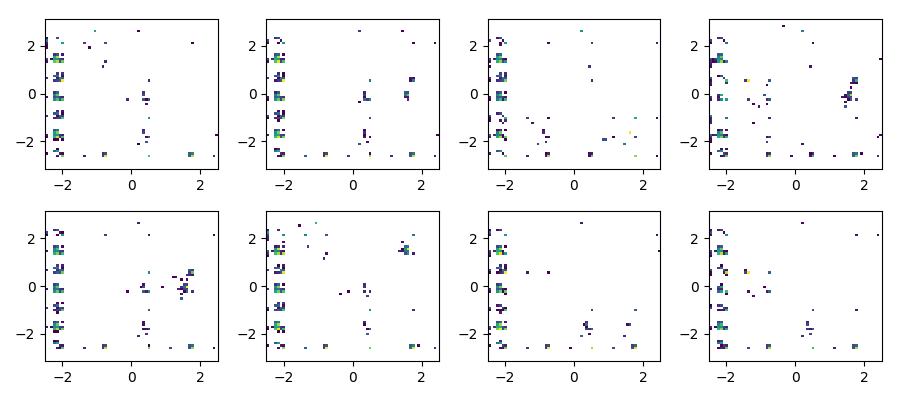

epoch 7


<IPython.core.display.Javascript object>


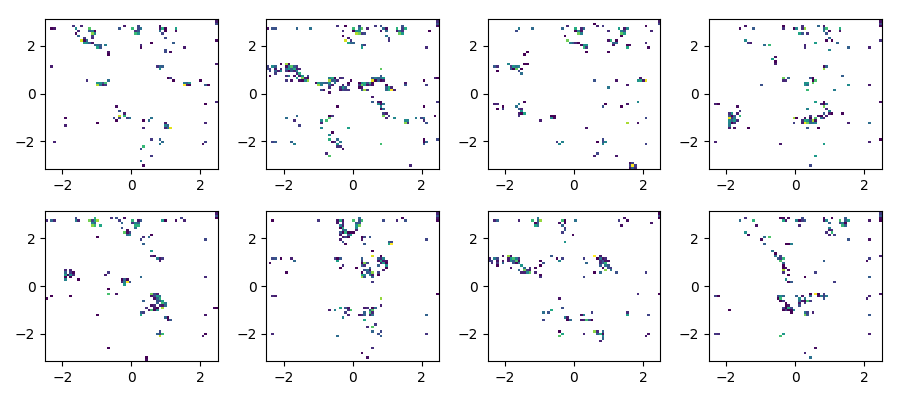

epoch 15


<IPython.core.display.Javascript object>


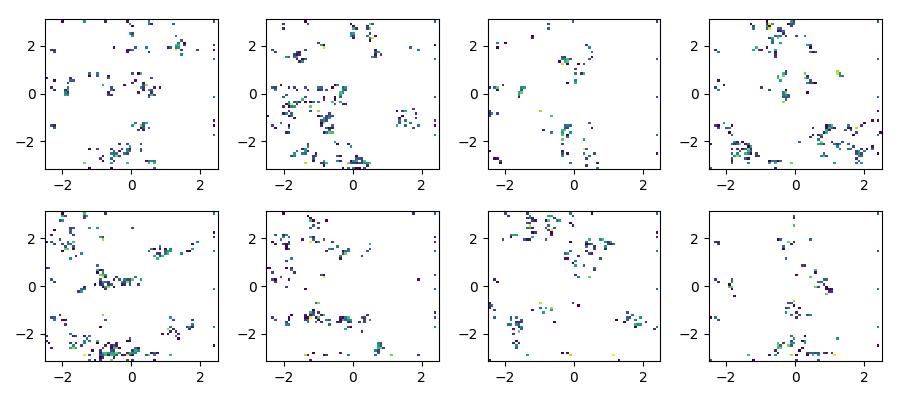

epoch 31


<IPython.core.display.Javascript object>


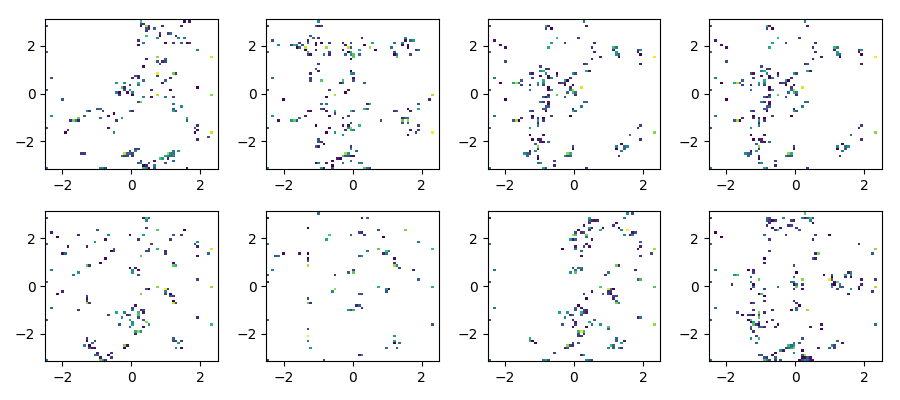

In [11]:
# Draw some samples from selected epoch
epochs = [0, 1, 2, 7, 15, 31]
for epoch in epochs:
    print('epoch', epoch)
    fig, axs = plt.subplots(2, 4, figsize=(9,4))
    for i, ax in enumerate(axs.flatten()):
        draw_image(corrected_gen_samples[epoch, i], vmin=1e-4, ax=ax,
                   draw_cbar=False, xlabel=None, ylabel=None)
    plt.tight_layout()

## Generate new samples

In [12]:
# Config
n_gen = 16

In [13]:
samples = correct_samples(generate_samples(generator, n_gen))

<IPython.core.display.Javascript object>


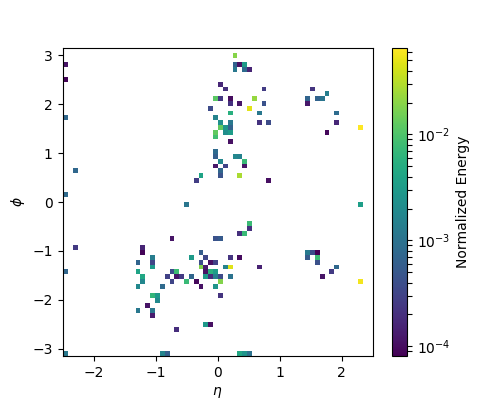

<IPython.core.display.Javascript object>


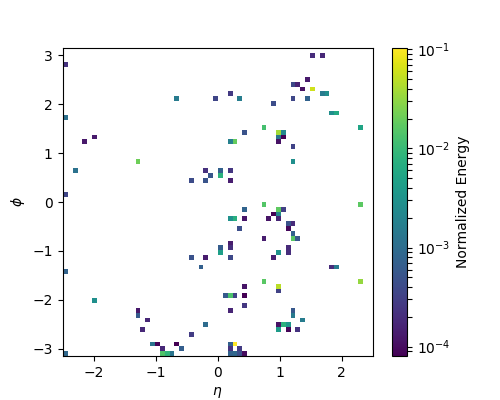

<IPython.core.display.Javascript object>


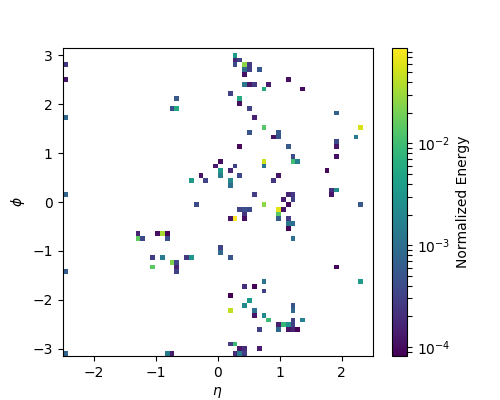

<IPython.core.display.Javascript object>


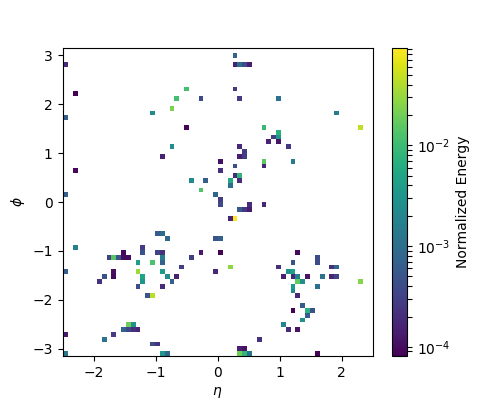

In [14]:
draw_image(samples[0])
draw_image(samples[1])
draw_image(samples[2])
draw_image(samples[3])

## Try FastJet reconstruction on the generated images

In [19]:
build_jets(samples[4])

[PseudoJet(pt=967394.160, eta=0.453, phi=1.768, mass=481943.860),
 PseudoJet(pt=634169.050, eta=0.173, phi=-1.353, mass=244366.675),
 PseudoJet(pt=512887.638, eta=-1.224, phi=-1.599, mass=229463.938),
 PseudoJet(pt=235577.324, eta=1.220, phi=-1.397, mass=45348.893)]